In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/combined_labeled_eeg-alcohol-normal.csv')

In [ ]:
df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,label
0,0,10.712,8.759,5.829,2.411,-0.519,-2.472,-4.913,-6.866,-8.331,-8.820,-7.843,-5.890,-2.960,-0.031,3.387,5.829,8.270,10.712,12.665,14.130,14.130,12.177,8.759,24.000,3.418,1.953,0.000,-0.977,-0.488,-0.488,0.000,0.488,0.977,1.953,2.930,3.418,3.906,4.395,4.395,...,14.058,14.547,14.058,14.058,14.547,14.058,14.058,13.570,13.082,13.082,14.058,16.012,17.965,19.918,20.406,18.453,15.523,12.594,11.617,12.105,14.058,15.035,15.523,14.547,14.547,16.012,19.430,21.871,21.871,18.453,13.082,9.176,7.711,9.176,12.594,15.035,15.523,15.035,13.082,0
1,1,-14.791,-15.279,-14.303,-11.373,-10.396,-12.349,-16.256,-20.162,-22.115,-20.650,-16.744,-13.326,-10.885,-11.373,-13.326,-14.791,-15.279,-13.814,-10.396,-5.025,0.346,3.764,4.252,1.811,-2.096,-4.537,-5.514,-5.025,-5.514,-7.955,-11.861,32.000,4.313,4.801,5.778,7.243,8.219,7.731,5.778,...,-6.927,-8.392,-9.857,-10.834,-10.345,-8.392,-6.439,-4.974,-3.998,-4.486,-4.974,-4.974,-4.974,-5.463,-5.951,-4.974,-3.021,-0.092,1.373,1.862,1.862,2.838,3.815,4.303,2.350,-0.580,-2.533,-3.510,-3.510,-3.510,-2.045,-0.092,1.862,3.326,3.326,2.350,1.862,1.373,1.373,0
2,2,-4.272,-4.272,-4.761,-5.249,-5.737,-6.226,-6.714,-7.202,-7.690,-7.690,-7.690,-7.202,-6.226,-5.737,-4.761,-4.272,-4.272,-3.784,-2.319,-3.296,-3.784,-5.737,-7.690,24.000,-2.838,-2.350,-1.862,-1.373,-1.373,-1.862,-1.862,-1.373,0.092,0.580,0.092,-1.373,-2.350,-3.326,-3.815,...,-11.464,-11.953,-12.441,-11.953,-10.976,-10.488,-10.976,-11.953,-12.441,-10.976,-8.535,-5.605,-3.652,-3.652,-4.140,-4.140,-3.652,-3.164,-3.164,-4.140,-5.117,-6.093,-6.093,-4.628,-3.652,-4.628,-7.070,-9.511,-10.000,-7.558,-3.652,-1.699,-2.187,-4.140,-5.117,-3.652,-0.722,1.231,0.254,0
3,3,-12.024,-10.559,-11.536,-14.465,-18.372,-20.325,-18.860,-15.442,-12.024,-10.071,-8.606,-7.141,-5.676,-5.676,-6.165,-7.629,-8.118,-7.629,-7.141,-7.629,-9.583,-12.024,-14.465,-16.418,-17.395,-17.883,-17.883,-16.907,-14.465,-10.559,-6.165,-3.723,-3.723,-6.165,-8.606,-9.583,-8.606,-6.165,-4.211,...,-13.794,-20.142,-26.978,-30.396,-29.419,-24.536,-18.677,-14.282,-13.794,-15.747,-18.188,-19.653,-20.630,-21.606,-23.071,-24.048,-22.583,-18.677,-13.306,-9.399,-9.399,-12.817,-18.188,-24.048,-28.442,-31.372,-32.837,-32.349,-29.419,-24.536,-20.142,-18.188,-18.677,-20.630,-21.118,-19.165,-17.212,-16.724,-18.677,0
4,4,-12.319,-18.178,-13.295,-3.530,2.330,-0.600,-9.878,-18.178,-17.202,-4.995,12.095,23.814,21.861,5.259,-15.737,-26.967,-20.620,-0.600,17.955,20.396,2.330,-25.991,-46.010,-45.034,-24.038,2.330,16.978,12.095,-6.460,-23.549,-28.920,-20.131,-4.995,7.212,11.119,6.236,-5.483,-18.667,-28.920,...,-18.982,-19.470,-19.470,-18.494,-16.541,-14.099,-11.658,-10.681,-11.169,-11.169,-10.193,-7.751,-5.310,-2.380,-1.892,-3.357,-4.333,-5.798,-6.287,-5.310,-4.333,-3.357,-2.869,-2.380,-2.380,-1.892,-1.404,-0.916,0.061,0.549,-0.427,-4.333,-10.681,-18.005,-23.376,-25.818,-24.841,-20.447,-15.564,0


In [ ]:
df_n = df.iloc[:120,1:-1]
df_a = df.iloc[120:,1:-1]

In [ ]:
df_n.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,10.712,8.759,5.829,2.411,-0.519,-2.472,-4.913,-6.866,-8.331,-8.820,-7.843,-5.890,-2.960,-0.031,3.387,5.829,8.270,10.712,12.665,14.130,14.130,12.177,8.759,24.000,3.418,1.953,0.000,-0.977,-0.488,-0.488,0.000,0.488,0.977,1.953,2.930,3.418,3.906,4.395,4.395,4.395,...,13.082,14.058,14.547,14.058,14.058,14.547,14.058,14.058,13.570,13.082,13.082,14.058,16.012,17.965,19.918,20.406,18.453,15.523,12.594,11.617,12.105,14.058,15.035,15.523,14.547,14.547,16.012,19.430,21.871,21.871,18.453,13.082,9.176,7.711,9.176,12.594,15.035,15.523,15.035,13.082
1,-14.791,-15.279,-14.303,-11.373,-10.396,-12.349,-16.256,-20.162,-22.115,-20.650,-16.744,-13.326,-10.885,-11.373,-13.326,-14.791,-15.279,-13.814,-10.396,-5.025,0.346,3.764,4.252,1.811,-2.096,-4.537,-5.514,-5.025,-5.514,-7.955,-11.861,32.000,4.313,4.801,5.778,7.243,8.219,7.731,5.778,3.337,...,-5.463,-6.927,-8.392,-9.857,-10.834,-10.345,-8.392,-6.439,-4.974,-3.998,-4.486,-4.974,-4.974,-4.974,-5.463,-5.951,-4.974,-3.021,-0.092,1.373,1.862,1.862,2.838,3.815,4.303,2.350,-0.580,-2.533,-3.510,-3.510,-3.510,-2.045,-0.092,1.862,3.326,3.326,2.350,1.862,1.373,1.373
2,-4.272,-4.272,-4.761,-5.249,-5.737,-6.226,-6.714,-7.202,-7.690,-7.690,-7.690,-7.202,-6.226,-5.737,-4.761,-4.272,-4.272,-3.784,-2.319,-3.296,-3.784,-5.737,-7.690,24.000,-2.838,-2.350,-1.862,-1.373,-1.373,-1.862,-1.862,-1.373,0.092,0.580,0.092,-1.373,-2.350,-3.326,-3.815,-4.303,...,-11.953,-11.464,-11.953,-12.441,-11.953,-10.976,-10.488,-10.976,-11.953,-12.441,-10.976,-8.535,-5.605,-3.652,-3.652,-4.140,-4.140,-3.652,-3.164,-3.164,-4.140,-5.117,-6.093,-6.093,-4.628,-3.652,-4.628,-7.070,-9.511,-10.000,-7.558,-3.652,-1.699,-2.187,-4.140,-5.117,-3.652,-0.722,1.231,0.254
3,-12.024,-10.559,-11.536,-14.465,-18.372,-20.325,-18.860,-15.442,-12.024,-10.071,-8.606,-7.141,-5.676,-5.676,-6.165,-7.629,-8.118,-7.629,-7.141,-7.629,-9.583,-12.024,-14.465,-16.418,-17.395,-17.883,-17.883,-16.907,-14.465,-10.559,-6.165,-3.723,-3.723,-6.165,-8.606,-9.583,-8.606,-6.165,-4.211,-4.700,...,-9.399,-13.794,-20.142,-26.978,-30.396,-29.419,-24.536,-18.677,-14.282,-13.794,-15.747,-18.188,-19.653,-20.630,-21.606,-23.071,-24.048,-22.583,-18.677,-13.306,-9.399,-9.399,-12.817,-18.188,-24.048,-28.442,-31.372,-32.837,-32.349,-29.419,-24.536,-20.142,-18.188,-18.677,-20.630,-21.118,-19.165,-17.212,-16.724,-18.677
4,-12.319,-18.178,-13.295,-3.530,2.330,-0.600,-9.878,-18.178,-17.202,-4.995,12.095,23.814,21.861,5.259,-15.737,-26.967,-20.620,-0.600,17.955,20.396,2.330,-25.991,-46.010,-45.034,-24.038,2.330,16.978,12.095,-6.460,-23.549,-28.920,-20.131,-4.995,7.212,11.119,6.236,-5.483,-18.667,-28.920,-31.850,...,-18.005,-18.982,-19.470,-19.470,-18.494,-16.541,-14.099,-11.658,-10.681,-11.169,-11.169,-10.193,-7.751,-5.310,-2.380,-1.892,-3.357,-4.333,-5.798,-6.287,-5.310,-4.333,-3.357,-2.869,-2.380,-2.380,-1.892,-1.404,-0.916,0.061,0.549,-0.427,-4.333,-10.681,-18.005,-23.376,-25.818,-24.841,-20.447,-15.564


In [ ]:
df_a.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
235,3.479,2.991,2.014,1.526,1.526,1.526,1.526,0.549,-0.427,-0.916,-1.404,-1.404,-1.892,-2.380,-3.357,-3.845,-3.845,-3.845,-2.869,-2.869,-2.380,-2.869,-3.357,-3.845,-3.845,-3.845,-3.845,-4.333,-4.822,-5.310,-4.822,-3.845,-2.869,-1.892,-0.916,-0.916,-0.916,-0.916,-0.427,-0.427,...,-2.330,-3.306,-4.771,-5.747,-4.771,-3.794,-2.818,-3.306,-4.283,-4.771,-3.794,-1.841,-0.376,0.112,-0.376,-0.376,1.577,4.506,6.460,4.995,1.088,-3.306,-5.259,-4.771,-2.818,-1.841,-2.330,-3.306,-3.306,-2.818,-2.818,-4.283,-6.724,-8.189,-6.724,-3.306,-0.376,0.600,-0.376,-1.841
236,-2.330,-1.841,-0.376,1.088,2.065,1.577,1.088,1.088,1.088,1.577,2.065,2.065,2.553,3.042,3.042,3.042,2.553,1.577,0.600,0.600,1.088,1.577,2.065,0.600,-0.865,-2.818,-4.283,-4.283,-4.771,-5.259,-5.747,-6.236,-6.236,-5.259,-5.259,-5.747,-7.212,-7.212,-6.236,-4.283,...,-1.322,0.631,3.072,4.537,5.025,4.049,2.096,0.631,-0.346,-1.322,-2.299,-4.252,-5.229,-6.205,-5.717,-3.764,-2.299,-1.322,-1.322,-2.299,-2.787,-1.322,1.119,4.049,5.514,4.537,2.096,0.142,0.631,3.560,7.467,10.396,10.885,9.420,7.955,7.467,7.955,7.467,4.537,1.119
237,41.951,42.440,41.951,40.975,39.022,37.069,35.116,33.651,32.186,30.721,30.721,33.651,39.998,47.811,52.694,16.000,-2.197,-1.709,-0.244,1.709,2.686,2.686,2.686,2.197,2.686,2.686,3.174,3.174,3.174,2.686,1.709,1.709,1.709,2.686,3.174,3.662,4.150,4.150,4.639,5.127,...,16.571,16.571,17.059,17.548,17.548,17.059,15.594,14.618,13.641,14.130,14.618,16.083,17.059,17.059,17.548,18.036,18.524,19.012,19.501,19.012,18.524,17.548,17.059,17.059,18.036,19.501,19.989,20.477,19.989,18.524,17.059,16.083,16.083,16.083,17.059,19.012,21.454,23.895,25.360,25.360
238,-0.376,-0.865,-1.353,-1.353,-1.841,-1.841,-1.353,-0.865,-0.865,-0.376,-0.865,-1.353,-2.330,-2.818,-1.841,-0.376,1.088,1.088,-0.376,-2.330,-3.306,-3.794,-2.330,-0.865,1.088,2.065,2.553,3.042,3.530,4.018,3.530,2.553,1.577,0.112,-1.353,-2.330,-2.330,-1.353,0.600,40.000,...,5.290,4.801,4.801,3.825,3.337,1.872,0.895,0.895,1.872,3.337,5.290,5.778,6.266,6.755,6.755,6.755,5.778,3.825,1.383,-0.570,-1.546,-1.058,-0.570,0.407,0.895,1.383,2.360,2.848,3.337,3.337,2.848,3.337,4.313,6.266,7.243,7.731,7.731,6.755,6.755,6.266
239,5.778,5.290,4.801,3.825,2.848,2.360,1.383,0.407,-0.570,-1.058,-0.570,0.407,1.383,1.383,0.895,-0.081,-1.058,-2.035,-2.523,-3.499,-3.988,-3.988,-3.499,-2.035,-0.570,-0.081,-1.058,-2.035,-3.988,-4.964,-4.964,-3.988,-2.523,-1.058,-0.081,-0.081,-0.081,-1.058,-2.035,-3.499,...,8.392,6.439,4.974,3.021,0.580,-0.885,-1.862,-1.862,-0.885,-1.373,-2.838,-4.303,-5.768,-5.768,-4.791,-2.838,-1.373,-0.397,-0.397,-1.373,-2.350,-3.815,-3.815,-3.326,-2.350,-2.838,-5.280,-7.721,-9.186,-8.698,-6.256,-4.303,-3.815,-4.791,-6.744,-8.209,-9.186,-10.651,-12.604,-14.069


In [ ]:
df.columns

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '2039', '2040', '2041', '2042', '2043', '2044', '2045', '2046', '2047',
       'label'],
      dtype='object', length=2050)

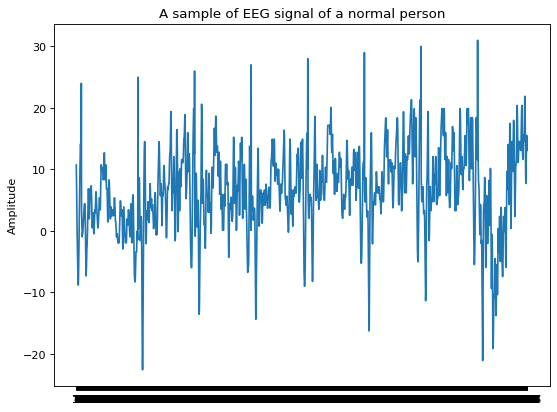

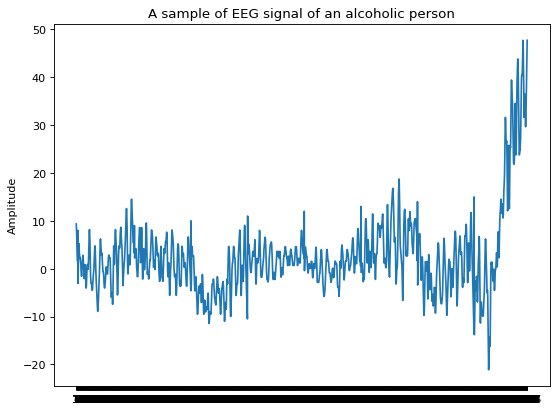

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

sample = df_n.iloc[0,:]
    
#plt.xlabel('False Positive Rate')
plt.ylabel('Amplitude')
plt.title('A sample of EEG signal of a normal person')
# plt.legend(loc="lower right")
plt.plot(sample)
plt.show()

plt.figure(figsize=(8, 6), dpi=80)
sample = df_a.iloc[0,:]
    
#plt.xlabel('False Positive Rate')
plt.ylabel('Amplitude')
plt.title('A sample of EEG signal of an alcoholic person')
# plt.legend(loc="lower right")
plt.plot(sample)
plt.show()

In [ ]:
def subsample(df_in, sampling):
    '''
    returns a df with subsampling of sampling
    Example: Original frequency 2048. If given sampling = 8, it returns frequency 2048/8 = 256.
    Return shape of df = [len(df) * frequency, len(df) // frequency]
    '''
    
    length = df_in.shape[1]
    #print(length)
    features = length // sampling
    #print(features)
    df_new = pd.DataFrame(columns=range(features))
    df_in = pd.DataFrame(df_in)
    #print(len(range(features)))
    for i in range(sampling):
        temp = df_in.iloc[:, i*features : i*features + features]
        temp.columns = range(features)
        df_new = df_new.append(temp, ignore_index=True)
    
    return df_new

In [ ]:
def prepare_data(df_n, df_a, sampling = 8, normalized = False):
    
    '''
    Divide the original signal into sampling parts
    '''

    if normalized:
        print(normalized)
        df_n = (df_n - df_n.mean())/df_n.std()
        df_a = (df_a - df_a.mean())/df_a.std()
        
#     display(df_n.describe())   
#     display(df_a.describe())  
    df_n_new = subsample(df_n, sampling)
    df_a_new = subsample(df_a, sampling)

    if df_n_new.shape[0] != df_n.shape[0] * sampling & df_a_new.shape[0] != df_a.shape[0] * sampling:
        print("Error in dimensions")
        return None
    
    df_n_new["label"] = 0
    df_a_new["label"] = 1
    df = pd.concat([df_n_new, df_a_new])
#     df = df.sample(frac=1) # randomize
    
    return df

In [ ]:
df = prepare_data(df_n, df_a, 4, normalized=False)
df = df.reset_index(drop=True)
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,label
count,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,...,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000
mean,-0.918493,-0.752176,-0.827757,-0.660567,-0.754643,-0.468968,-0.549273,-0.217778,-0.328166,0.007648,-0.188039,0.134948,-0.177078,0.225292,-0.089121,0.208140,-0.294564,0.208050,-0.372621,0.288154,-0.326325,0.308622,-0.410168,0.372156,-0.312033,0.649025,-0.096075,0.779161,-0.127957,0.738092,-0.236230,0.755578,-0.325206,0.750209,-0.418822,0.675866,-0.510780,0.746575,-0.430821,0.911025,...,-1.226854,-1.303654,-1.331127,-1.364686,-1.368759,-1.380962,-1.308230,-1.198361,-1.103239,-1.077320,-1.090531,-1.200896,-1.254841,-1.261431,-1.157175,-1.004591,-0.866739,-0.774173,-0.763492,-0.757898,-0.694307,-0.577828,-0.452194,-0.339273,-0.257908,-0.245191,-0.301144,-0.390658,-0.477647,-0.526983,-0.512743,-0.450174,-0.453220,-0.529523,-0.701945,-0.849466,-0.934898,-0.914571,-0.886591,0.500000
std,10.263553,10.046535,10.015053,9.707094,9.617062,9.733427,9.850249,9.974861,9.945073,10.009217,10.079600,10.487825,10.580713,10.767200,10.585485,9.838526,9.261510,9.630593,9.215101,9.884407,9.304727,10.045572,9.452362,10.240087,9.284806,10.151472,9.179318,10.150888,9.052892,10.433177,9.301074,10.496619,8.856556,10.405033,8.478708,10.665844,8.831327,11.141151,9.029159,11.509757,...,9.315337,9.275759,9.364134,9.474199,9.512239,9.517192,9.308929,9.150457,9.097438,9.119883,9.140022,9.239197,9.276982,9.401548,9.417079,9.451608,9.538923,9.614800,9.729220,9.794746,9.707579,9.589334,9.443840,9.359453,9.393794,9.487357,9.609703,9.582394,9.560410,9.588319,9.666413,9.726513,9.745196,9.835227,9.922660,9.938953,9.977972,9.966704,10.010211,0.500261
min,-57.465000,-56.976000,-54.047000,-47.699000,-41.361000,-44.464000,-41.046000,-38.310000,-43.599000,-47.994000,-51.412000,-52.389000,-51.412000,-53.792000,-53.792000,-50.374000,-44.027000,-44.464000,-45.441000,-42.999000,-46.906000,-41.046000,-46.010000,-45.034000,-32.542000,-34.210000,-34.566000,-37.984000,-41.402000,-40.426000,-39.449000,-42.379000,-41.402000,-44.820000,-45.308000,-45.797000,-45.400000,-47.353000,-48.818000,-49.306000,...,-53.070000,-52.094000,-47.211000,-46.285000,-44.332000,-40.914000,-41.534000,-36.519000,-37.496000,-39.937000,-37.140000,-36.214000,-35.675000,-40.181000,-42.623000,-49.459000,-57.271000,-63.619000,-67.037000,-67.037000,-63.131000,-56.295000,-48.482000,-40.680000,-39.215000,-37.984000,-38.961000,-35.055000,-34.475000,-38.381000,-39.846000,-43.538000,-45.980000,-45.003000,-40.120000,-37.913000,-39.866000,-41.819000,-43.284000,0.000000
25%,-6.149250,-5.768000,-5.890000,-5.773000,-5.920000,-5.696500,-5.778250,-5.366250,-5.234000,-5.000000,-4.849750,-5.007500,-5.290000,-4.839500,-4.798750,-4.496000,-4.549500,-4.569750,-4.842000,-4.679000,-4.583000,-4.710000,-5.175500,-4.817000,-5.022750,-4.419750,-5.022750,-4.364250,-4.885500,-4.956500,-4.981750,-4.763500,-4.679250,-4.476000,-4.766000,-4.720000,-5.122000,-4.407500,-4.664000,-4.575000,...

In [ ]:
def get_data_split(df, normalize=False):

    df_train, df_test = train_test_split(df, test_size=0.2, random_state=1234) #1337) #, stratify=df_normalized['label'])

    Y_train = np.array(df_train['label'].values).astype(np.int8)
    X_train = np.array(df_train.drop(['label'], axis=1).values)[..., np.newaxis]
    #X_train = df_train.drop(['label'], axis=1).values

    Y_test = np.array(df_test['label'].values).astype(np.int8)
    X_test = np.array(df_test.drop(['label'], axis=1).values)[..., np.newaxis]
    #X_test = df_test.drop(['label'], axis=1).values
    
    if normalize:
        print("Normalizing...")
        X_train = (X_train - X_train.mean()) / X_train.std()
        X_test = (X_test - X_test.mean()) / X_test.std()
        
    print("X_train:", X_train.shape)
    print("X_test :",X_test.shape)
    print("Y_train:", Y_train.shape)
    print("Y_test :",Y_test.shape)
    
    return (X_train, Y_train), (X_test, Y_test)

In [ ]:
(X_train, Y_train), (X_test, Y_test) = get_data_split(df, normalize=True)

Normalizing...
X_train: (768, 512, 1)
X_test : (192, 512, 1)
Y_train: (768,)
Y_test : (192,)


In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,label
0,10.712,8.759,5.829,2.411,-0.519,-2.472,-4.913,-6.866,-8.331,-8.820,-7.843,-5.890,-2.960,-0.031,3.387,5.829,8.270,10.712,12.665,14.130,14.130,12.177,8.759,24.000,3.418,1.953,0.000,-0.977,-0.488,-0.488,0.000,0.488,0.977,1.953,2.930,3.418,3.906,4.395,4.395,4.395,...,9.633,8.169,7.192,7.680,10.122,11.587,11.587,11.587,11.587,11.098,11.098,11.098,11.587,12.075,13.540,14.516,15.004,15.004,15.981,17.446,18.911,18.422,15.493,11.098,7.192,5.239,5.727,6.215,7.192,7.680,9.145,11.587,14.516,15.981,15.004,12.563,10.122,9.633,10.610,0
1,-14.791,-15.279,-14.303,-11.373,-10.396,-12.349,-16.256,-20.162,-22.115,-20.650,-16.744,-13.326,-10.885,-11.373,-13.326,-14.791,-15.279,-13.814,-10.396,-5.025,0.346,3.764,4.252,1.811,-2.096,-4.537,-5.514,-5.025,-5.514,-7.955,-11.861,32.000,4.313,4.801,5.778,7.243,8.219,7.731,5.778,3.337,...,-4.181,-5.646,-9.064,-11.993,-12.482,-9.552,-4.669,-1.251,1.678,3.143,6.073,9.979,13.885,14.862,13.397,10.956,9.491,8.514,7.050,4.120,-2.228,-7.599,-10.529,-10.040,-6.622,-2.716,-0.763,0.214,-0.275,-1.740,-3.204,-4.669,-4.669,-3.693,-1.740,0.702,2.167,1.190,-1.740,0
2,-4.272,-4.272,-4.761,-5.249,-5.737,-6.226,-6.714,-7.202,-7.690,-7.690,-7.690,-7.202,-6.226,-5.737,-4.761,-4.272,-4.272,-3.784,-2.319,-3.296,-3.784,-5.737,-7.690,24.000,-2.838,-2.350,-1.862,-1.373,-1.373,-1.862,-1.862,-1.373,0.092,0.580,0.092,-1.373,-2.350,-3.326,-3.815,-4.303,...,-3.235,-5.188,-6.653,-6.653,-6.165,-4.700,-4.211,-4.700,-5.676,-6.653,-7.141,-7.629,-9.583,-11.536,-13.489,-14.465,-13.977,-12.512,-11.047,-9.583,-9.094,-8.606,-8.118,-8.118,-8.118,-9.094,-9.583,-10.559,-11.047,-11.536,-12.024,-13.489,-16.418,-17.883,-19.836,-20.325,-17.883,-14.954,-12.024,0
3,-12.024,-10.559,-11.536,-14.465,-18.372,-20.325,-18.860,-15.442,-12.024,-10.071,-8.606,-7.141,-5.676,-5.676,-6.165,-7.629,-8.118,-7.629,-7.141,-7.629,-9.583,-12.024,-14.465,-16.418,-17.395,-17.883,-17.883,-16.907,-14.465,-10.559,-6.165,-3.723,-3.723,-6.165,-8.606,-9.583,-8.606,-6.165,-4.211,-4.700,...,-10.020,-7.579,-6.602,-7.579,-8.067,-8.067,-7.579,-7.579,-8.555,-9.532,-10.020,-8.555,-5.137,-1.231,2.187,4.140,4.140,2.187,-0.743,-4.161,-6.602,-7.090,-5.625,-3.672,-2.207,-2.696,-4.161,-5.625,-5.625,-4.161,-1.719,0.234,0.722,0.234,-1.231,-3.184,-5.137,-6.114,-6.602,0
4,-12.319,-18.178,-13.295,-3.530,2.330,-0.600,-9.878,-18.178,-17.202,-4.995,12.095,23.814,21.861,5.259,-15.737,-26.967,-20.620,-0.600,17.955,20.396,2.330,-25.991,-46.010,-45.034,-24.038,2.330,16.978,12.095,-6.460,-23.549,-28.920,-20.131,-4.995,7.212,11.119,6.236,-5.483,-18.667,-28.920,-31.850,...,-19.246,-17.782,-12.410,-6.063,-0.692,1.261,0.773,-0.692,-1.180,-0.203,0.285,-1.668,-4.110,-5.086,-1.668,5.656,12.980,15.422,12.492,5.656,0.285,-1.180,0.773,3.215,2.726,-0.692,-6.063,-12.410,-19.246,-25.594,-29.500,-29.012,-23.153,-14.852,-7.528,-2.157,0.285,2.238,4.679,0


In [ ]:
df.shape

(960, 513)

In [ ]:
print(X_train.shape)
print(X_train.mean(), X_train.std())
print(X_test.mean(), X_test.std())

print(Y_train) # random distribution

(768, 512, 1)
-2.2551405187698492e-17 1.0
-1.0408340855860843e-17 1.0
[1 1 0 1 1 0 1 1 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0
 1 1 0 1 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 0 0 1 1 0 1
 1 1 1 1 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0
 0 1 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0 0 1 1 1 0 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1
 0 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 0 0 1 1
 0 0 1 1 1 0 1 1 1 1 0 0 0 1 0 1 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 1 1 1 1
 1 0 1 0 1 0 1 0 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 0
 0 1 1 1 0 1 0 1 0 0 1 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0 0 1 0 1 1 0 1 0 0 1 0
 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1
 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 0 0 1 0 1 0 0 0 0
 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 0 1
 1 0 1 0 0 0 1 0 1 0 1 1 1 0 1

Sequential - Conv1D
Simple - unoptimized version

In [ ]:
from keras.models import Sequential
from keras import regularizers
from keras.layers import BatchNormalization
from keras.layers import Flatten

def create_seq_model(shape):
    model = Sequential()

    model.add(Convolution1D(16, 15, activation='relu', name="Conv1D_1", input_shape = shape))
    model.add(MaxPool1D(2, name="MaxPool_1"))
    
    model.add(Convolution1D(32, 15, activation='relu', name="Conv1D_2"))
    model.add(MaxPool1D(2, name="MaxPool_2"))
    
    model.add(Convolution1D(64, 15,  activation='relu', name="Conv1D_3a"))            
    model.add(Convolution1D(64, 15,  activation='relu', name="Conv1D_3b"))
    model.add(GlobalMaxPool1D(name="MaxPool_3"))
            
    model.add(Dense(1, activation='sigmoid', 
                    name="Dense_FC"))
    return model

Regularized version

In [ ]:
from keras.models import Sequential
from keras import regularizers
from keras.layers import BatchNormalization
from keras.layers import Flatten

def create_seq_model(shape):
    model = Sequential()
    
    model.add(Convolution1D(16, 15, input_shape = shape, activation='relu', name="Conv1D_1"))
    model.add(MaxPool1D(2, name="MaxPool_1"))
    model.add(BatchNormalization(name="Normalization_1"))
    model.add(Dropout(rate=0.4, name="Dropout_1"))

    model.add(Convolution1D(32, 15, activation='relu', name="Conv1D_2"))
    model.add(MaxPool1D(2, name="MaxPool_2"))
    model.add(BatchNormalization(name="Normalization_2"))
    model.add(Dropout(rate=0.4, name="Dropout_2"))
    
    model.add(Convolution1D(64, 15,  activation='relu', name="Conv1D_3a"))        
    model.add(Convolution1D(64, 15,  activation='relu', name="Conv1D_3b"))

    model.add(GlobalMaxPool1D(name="MaxPool_3"))
    model.add(BatchNormalization(name="Normalization_3"))
    model.add(Dropout(rate=0.4, name="Dropout_3"))
            
    model.add(Dense(1, activation='sigmoid', 
                    kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), 
                    name="Dense_Final_Sigmoid", ))
    
    return model

In [ ]:
model = create_seq_model(X_train[0].shape)
model.summary()
#model.get_config()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 498, 16)           256       
_________________________________________________________________
MaxPool_1 (MaxPooling1D)     (None, 249, 16)           0         
_________________________________________________________________
Normalization_1 (BatchNormal (None, 249, 16)           64        
_________________________________________________________________
Dropout_1 (Dropout)          (None, 249, 16)           0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 235, 32)           7712      
_________________________________________________________________
MaxPool_2 (MaxPooling1D)     (None, 117, 32)           0         
_________________________________________________________________
Normalization_2 (BatchNormal (None, 117, 32)           1

Actual model fitting with found LR

In [ ]:
from tensorflow.keras import optimizers

In [ ]:
model.compile(optimizer=optimizers.RMSprop(lr=0.0001), loss=losses.binary_crossentropy, metrics=['accuracy'])
early = EarlyStopping(monitor="loss", mode="min", patience=10, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.9, patience=8, verbose=2)
checkpoint_cb = ModelCheckpoint("Best_Model.h5", save_best_only=True)
callbacks_list = [early, checkpoint_cb, redonplat]

history = model.fit(X_train, Y_train, epochs=20, 
                    batch_size=32, 
                    verbose=2, 
                    callbacks= [checkpoint_cb], 
                    validation_split=0.2)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
20/20 - 33s - loss: 0.7970 - accuracy: 0.6124 - val_loss: 0.7836 - val_accuracy: 0.5779
Epoch 2/20
20/20 - 0s - loss: 0.7470 - accuracy: 0.6498 - val_loss: 0.7993 - val_accuracy: 0.4870
Epoch 3/20
20/20 - 0s - loss: 0.7128 - accuracy: 0.6954 - val_loss: 0.8271 - val_accuracy: 0.4740
Epoch 4/20
20/20 - 0s - loss: 0.6269 - accuracy: 0.7427 - val_loss: 0.8571 - val_accuracy: 0.4740
Epoch 5/20
20/20 - 0s - loss: 0.6608 - accuracy: 0.7443 - val_loss: 0.8687 - val_accuracy: 0.4740
Epoch 6/20
20/20 - 0s - loss: 0.6491 - accuracy: 0.7410 - val_loss: 0.9008 - val_accuracy: 0.4740
Epoch 7/20
20/20 - 0s - loss: 0.6368 - accuracy: 0.7590 - val_loss: 0.9123 - val_accuracy: 0.4740
Epoch 8/20
20/20 - 0s - loss: 0.6379 - accuracy: 0.7394 - val_loss: 0.9195 - val_accuracy: 0.4805
Epoch 9/20
20/20 - 0s - loss: 0.5898 - accuracy: 0.7687 - val_loss: 0.9181 - val_accuracy: 0.4805
Epoch 10/20
20/20 - 0s - loss: 0.6141 - accuracy: 0.7866 - val_loss: 0.8997 - val_accuracy: 0.4805
Epoch 11/20
20/20 

In [ ]:
old_history = history.history
print(len(history.history['loss']))
print(len(old_history['loss']))

20
20


In [ ]:
model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))
#plot_acc_loss(history.history)

Test Accuracy: 64.583%


In [ ]:
best_model = models.load_model("Best_Model.h5")
model_acc = best_model.evaluate(X_test, Y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Test Accuracy: 64.583%


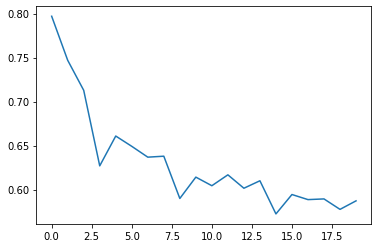

In [ ]:
plt.plot(history.history['loss'])

K-fold cross validation

In [ ]:
train_data = X_train #[:, :-1] #.drop(['label'], axis=1)
train_targets = Y_train #[:, -1] #'label']
print(train_data.shape, train_targets.shape)

(768, 512, 1) (768,)


In [ ]:
segments = 8
df = prepare_data(df_n, df_a, segments, normalized=False)
df = df.reset_index(drop=True)
(X_train, Y_train), (X_test, Y_test) = get_data_split(df, normalize=True)

num_batch = [2**i for i in range(3)] #range(10)
num_folds = [5] #[3, 5, 10]
num_epochs = [100] #[100, 200]
num_feats = 2048 // segments   #[2048 // seg for seg in num_segs]
print(num_feats)

all_scores = []

for k in num_folds:
    all_scores = []
    for i in range(k):
        for epochs in num_epochs:
            printed = True
            for batch_size in num_batch:
                num_val_samples = len(X_train) // k

#                 print('processing fold #', i+1)
                val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
                val_targets = Y_train[i * num_val_samples: (i + 1) * num_val_samples]
                partial_train_data = np.concatenate(
                [X_train[:i * num_val_samples],
                X_train[(i + 1) * num_val_samples:]],
                axis=0)
                partial_train_targets = np.concatenate(
                [Y_train[:i * num_val_samples],
                Y_train[(i + 1) * num_val_samples:]],
                axis=0)
                if printed:
                    print(segments, num_feats, partial_train_data.shape[0], val_data.shape[0], X_test.shape[0], 
                          batch_size, epochs, k)
                model = create_seq_model(X_train[0].shape)
                model.compile(optimizer=optimizers.RMSprop(lr=0.0001), loss=losses.binary_crossentropy, metrics=['accuracy'])
                model.fit(partial_train_data, partial_train_targets,epochs=epochs, batch_size=batch_size, verbose=0)
                val_loss, val_acc = model.evaluate(val_data, val_targets, verbose=1)
                all_scores.append(val_acc)
                printed = False

print("%.2f(%.2f)" % (np.mean(all_scores), np.std(all_scores)))

test_loss_score, test_acc_score = model.evaluate(X_test, Y_test, verbose=0)
print("Test accuracy: %.2f" % test_acc_score)

Normalizing...
X_train: (1536, 256, 1)
X_test : (384, 256, 1)
Y_train: (1536,)
Y_test : (384,)
256
8 256 1229 307 384 1 100 5


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


10/10 [==============================] - 0s 4ms/step - loss: 0.3013 - accuracy: 0.9023
8 256 1229 307 384 1 100 5
10/10 [==============================] - 0s 4ms/step - loss: 0.2596 - accuracy: 0.9153
8 256 1229 307 384 1 100 5
10/10 [==============================] - 0s 4ms/step - loss: 0.3023 - accuracy: 0.9055
8 256 1229 307 384 1 100 5
10/10 [==============================] - 0s 5ms/step - loss: 0.3010 - accuracy: 0.9055
8 256 1229 307 384 1 100 5
10/10 [==============================] - 0s 4ms/step - loss: 0.3429 - accuracy: 0.8697
0.74(0.17)
Test accuracy: 0.88


In [ ]:
import numpy as np
k = 3
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
    [train_data[:i * num_val_samples],
    train_data[(i + 1) * num_val_samples:]],
    axis=0)
    partial_train_targets = np.concatenate(
    [train_targets[:i * num_val_samples],
    train_targets[(i + 1) * num_val_samples:]],
    axis=0)
    print(partial_train_data.shape, partial_train_targets.shape)
    model = create_seq_model(train_data[0].shape)
    model.compile(optimizer=optimizers.RMSprop(lr=0.0001), loss=losses.binary_crossentropy, metrics=['accuracy'])
    model.fit(partial_train_data, partial_train_targets,
    epochs=num_epochs, batch_size=2, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=1)
    all_scores.append(val_mae)

NameError: ignored

In [ ]:
np.mean(all_scores)

NameError: ignored

In [ ]:
np.std(all_scores)

In [ ]:
test_loss_score, test_acc_score = model.evaluate(X_test, Y_test)

In [ ]:
import numpy as np
k = 5
num_val_samples = len(train_data) // k
num_epochs = 100
all_acc_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
    [train_data[:i * num_val_samples],
    train_data[(i + 1) * num_val_samples:]],
    axis=0)
    partial_train_targets = np.concatenate(
    [train_targets[:i * num_val_samples],
    train_targets[(i + 1) * num_val_samples:]],
    axis=0)
    model = create_seq_model(X_train[0].shape)
    history = model.fit(partial_train_data, partial_train_targets,
                validation_data=(val_data, val_targets),
                 epochs=num_epochs, batch_size=1, verbose=1)
    acc_history = history.history['val_accuracy']
    al_acc_histories.append(acc_history)

In [ ]:
model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))
plot_acc_loss(history)

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file="model_4.png", dpi=72, show_shapes=True, expand_nested=True)

In [ ]:
Y_test.reshape(Y_test.shape[0], 1).shape
#reshape(X_train.shape[0], 2048,1).astype('float32')
Y_test.shape

Other metrics: precision, recall, Kappa, AUC, Fa-socre
Using the best model

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, \
    confusion_matrix, roc_curve, auc
pred = best_model.predict(X_test.reshape(X_test.shape[0], 512,1).astype('float32'))
predict_classes = best_model.predict_classes(X_test.reshape(X_test.shape[0], 512,1).astype('float32'))
print(Y_test.shape)
print(predict_classes.shape)
correct = accuracy_score(Y_test, predict_classes)
print(f"Testing Accuracy: {correct}")

In [ ]:
# precision tp / (tp + fp)
precision = precision_score(Y_test, predict_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, predict_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, predict_classes)
print('F1 score: %f' % f1)

In [ ]:
#kappa
kappa = cohen_kappa_score(Y_test, predict_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc_ = roc_auc_score(Y_test, predict_classes)
print('ROC AUC: %f' % auc_)
# confusion matrix
matrix = confusion_matrix(Y_test, predict_classes)
print(matrix)

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, predict_classes[:, 0], pos_label=1)
print(fpr)
print(tpr)
print(thresholds)

In [ ]:
# roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_) #roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import itertools

plt.imshow(matrix,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix without Normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(2) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = matrix.max() / 2.
for i,j in itertools.product(range(matrix.shape[0]),range(matrix.shape[1])):
    plt.text(j,i,format(matrix[i,j],'d'),horizontalalignment='center',color='white' if matrix[i,j] >thresh else 'black')
plt.show();

In [ ]:
from sklearn.metrics import accuracy_score
pred = model.predict(X_test.reshape(X_test.shape[0], 512,1).astype('float32'))
print(pred)
predict_classes = np.argmax(pred,axis=1)
print(predict_classes)
expected_classes = Y_test.reshape(Y_test.shape[0], 1)
print(expected_classes.shape)
print(predict_classes.shape)
correct = accuracy_score(expected_classes,predict_classes)
print(f"Testing Accuracy: {correct}")

Using PyOD for removing outliers

In [ ]:
!pip install pyod

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# PyOD
from tensorflow.keras import backend as k
from pyod.utils.data import generate_data
from pyod.models.auto_encoder import AutoEncoder
from keras.utils import plot_model

In [ ]:
sns.scatterplot(x=0, y=1, data=df);
plt.title('Original Data only with 2 dimension out of ' + str(df.shape[1] - 1));

In [ ]:
contamination = 0.1 
epochs = 50

In [ ]:
clf = AutoEncoder(epochs=epochs, contamination=contamination)
clf.fit(df[df.columns[:-1]])

In [ ]:
y_train_pred = clf.labels_  
y_train_scores = clf.decision_scores_ 

In [ ]:
plt.plot(y_train_scores);
plt.axhline(y=clf.threshold_, c='r', ls='dotted', label='threshoold');
plt.title('Anomaly Scores with automatically calculated threshold');

In [ ]:
sns.scatterplot(x=0, y=1, hue=y_train_scores, data=df, palette='RdBu_r');
plt.title('Anomaly Scores by PCA');

In [ ]:
outliers = np.where(y_train_scores > 32)
df.iloc[outliers]

In [ ]:
df_clean  = df.drop(df.iloc[outliers].index, axis=0)
df_clean
#df.drop([outliers], axis=0)

For finding best LR

In [ ]:
10**(5 / 15)

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 18))

model.compile(optimizer=optimizers.RMSprop(lr=1e-6), loss=losses.binary_crossentropy, metrics=['accuracy'])

history_lr = model.fit(X_train, Y_train, epochs=100, 
                    batch_size=32, 
                    verbose=2, 
                    callbacks= [lr_schedule], 
                    validation_split=0.2)

In [ ]:
minloss = min(history_lr.history["loss"])
print(minloss)
idx = history_lr.history["loss"].index(minloss) + 1
print(idx)
mylr = history_lr.history["lr"][idx]
mylr = round(mylr, 5)
mylr

In [ ]:
plt.semilogx(history_lr.history["lr"], history_lr.history["loss"])
plt.axis([1e-4, 1, 0, 2])

In [ ]:
round(model.optimizer.lr.numpy(), 5)

In [ ]:
model.predict(X_test[0].reshape(X_test[0].shape[0],X_test[0].shape[1],1), Y_test[0])

In [ ]:
print_confusion_classification(model)

From chollet book. List 6.46

In [ ]:
import matplotlib.pyplot as plt
def plot_acc_loss(history):
    print(history.keys())
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.figure()
    plt.plot(epochs, acc,  label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

In [ ]:
pred_test = model.predict(X_test)
pred_test = (pred_test>0.5).astype(np.int8)
print(pred_test)
print(np.array(Y_test))

f1 = f1_score(np.array(Y_test), pred_test)

print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : {:.3f}%".format (acc*100))

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_classification(def_model):
    y_pred = np.array(list(map(lambda x: np.argmax(x), def_model.predict(X_test))))
    y_pred = (y_pred>0.191).astype(np.int8)
    
    cm = confusion_matrix(Y_test, y_pred)
    clr = classification_report(Y_test, y_pred, target_names=['0', '1'])

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
    plt.xticks(np.arange(2) + 0.5, ['0', '1'])
    plt.yticks(np.arange(2) + 0.5, ['0', '1'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    print("Classification Report:\n----------------------\n", clr)